# Tutorial on July 2023 record-breaking global surface temperatures using climate data from C3S

### About

In this tutorial we will access data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse air and sea surface temperatures comparing July 2023 record breaking values with climatologies. The tutorial comprises the following steps:
    
1. Search, download and view data

2. Calculate a global surface temperature climatology

3. Compute and visualise anomalies with respect to the climatology

4. View time series and rank global surface temperature records

5. Analyse North Atlantic sea surface temperature trends

![Example of work](img/reanalysis-temp-record-000.png)

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <td>Run the tutorial via free cloud platforms: </td>
    <td>
        <a target="_blank" href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=reanalysis-temp-record.ipynb">
            <img src="https://mybinder.org/badge.svg" alt="Binder"/>
        </a>
    </td>
    <td>
        <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/reanalysis-temp-record.ipynb">
            <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Kaggle"/>
        </a>
    </td>
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/reanalysis-temp-record.ipynb">
            <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Colab"/>
        </a>
    </td>
  </tr>
</table>

<br/>

## 1. Search, download and view data

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS as well as other required libs, and importing the various python libraries that we will need.

#### Infrastructure introduction (installing API of the CDS)

In this exercise we will mainly use `cdsapi`, `xarray`, `matplotlib` and `cartopy` python libraries.

There are several options to run the code in this tutorial:
- Installing everything on your computer.
- Running the code in free Jupyter services, such as Binder, Colab or Kaggle (see links above).

#### Installation on your computer

First of all, in order to run this notebook on your computer you need to install Python and the required libs.

The easiest way to install Python without interfering with other potential Python installations on your system is by using [Miniconda, Miniforge or Mambaforge](https://github.com/conda-forge/miniforge/blob/main/README.md). This will install a modern Python for your user and the **Conda**/**Mamba** package manager. **Mamba** is a performant drop-in replacement for **Conda**.

Once Python + **Conda**/**Mamba** are installed run the following from the command line to install the API of the CDS, `cdsapi`, and the rest of the requirements:

- With **Conda**:

`conda install -c conda-forge notebook numpy matplotlib cartopy xarray netCDF4 cdsapi -y`

- With **Mamba**:

`mamba install -c conda-forge notebook numpy matplotlib cartopy xarray netCDF4 cdsapi -y`

If everything is installed correctly run the following from the command line:

`cd /path/to/the/notebook`

`jupyter notebook`

And you will see the notebook interface open in your default webbrowser.

#### Running on Colab or Kaggle

If you are on Colab or Kaggle just run the following line of code to install the API of the CDS and the rest of the dependencies before running the rest of the code:

In [ ]:
!pip install numpy matplotlib cartopy xarray netCDF4 cdsapi

#### Import libraries

We will start importing the required libraries. These libs should be already installed. If you have not installed the requirements, please go to the specific section above.

In [1]:
import urllib3
urllib3.disable_warnings()

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cdsapi

plt.style.use('bmh')

#### Enter your CDS API key

We will request data from the CDS programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First you have to define two variables: `URL` and `APIKEY` which build together your CDS API key. The string of characters that make up your APIKEY include your personal User ID and CDS API key. To obtain these, first register and login to the CDS (https://cds-beta.climate.copernicus.eu), then visit https://cds-beta.climate.copernicus.eu/how-to-api and copy the string of characters listed after "key:". Replace the `Your-api-key` below with this string.

In [2]:
URL = "https://cds-beta.climate.copernicus.eu/api"
# Here you shall use your UUID and api key replacing "UUID:Your-api-key" with the values in your user profile in CDS
# For instance "1234:ecmwf123-4567-89ec-mwf1-23456789ecmf" or something like that
APIKEY = "Your-api-key"

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [3]:
DATADIR = './'

#### Search for data

To search for data, visit the CDS website: https://cds-beta.climate.copernicus.eu.
Here you can search for ERA5 data using the search bar. The data we need for this tutorial is the [ERA5 monthly averaged data on single levels from 1940 to present](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=overview). ERA5 is the 5th version of the ECMWF Reanalysis dataset. Reanalysis uses a state of the art forecast model and data assimilation system to create a consistent "map without gaps" of observed and modelled climate variables over the past decades.

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Product type: `Monthly averaged reanalysis`
- Variable: `2m temperature`
- Year: `1940 to present year`
- Month: `july`
- Time: `00:00` (default)
- Geographical area: `Sub-region extraction` and leave the default values, `'area': [90, -180, -90, 180], # maxlat, minlon, minlat, maxlon` (this will be explained further below)
- Format: `NetCDF`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below) ...

<center><img src="img/reanalysis-temp-record-001.png" /></center>

#### Download data

... having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory. However, before you run the cell below, the **terms and conditions** of this particular dataset need to have been accepted in the CDS. The option to view and accept these conditions is given at the end of the download form, just above the **"Show API request"** option.

In [4]:
c = cdsapi.Client(url=URL, key=APIKEY)
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'data_format': 'netcdf_legacy',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': '2m_temperature',
        'year': [
            '1940', '1941', '1942',
            '1943', '1944', '1945',
            '1946', '1947', '1948',
            '1949', '1950', '1951',
            '1952', '1953', '1954',
            '1955', '1956', '1957',
            '1958', '1959', '1960',
            '1961', '1962', '1963',
            '1964', '1965', '1966',
            '1967', '1968', '1969',
            '1970', '1971', '1972',
            '1973', '1974', '1975',
            '1976', '1977', '1978',
            '1979', '1980', '1981',
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
            '2021', '2022', '2023',
        ],
        'month': '07',
        'time': '00:00',
        'area': [90, -180, -90, 180], # maxlat, minlon, minlat, maxlon
    },
    f'{DATADIR}t2m_global_july_1940-2023.nc'
)

2024-06-16 21:46:19,158 INFO Welcome to the CDS
2024-06-16 21:46:19,158 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2024-06-16 21:46:19,282 INFO Request is queued
2024-06-16 21:46:20,347 INFO Request is running
2024-06-16 21:46:40,413 INFO Request is completed
2024-06-16 21:46:40,413 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data5/adaptor.mars.internal-1718567197.247748-30483-9-b46e2bfe-4461-43da-a87b-bd7e7a603f2a.nc to ./DATA-2024-06-16/t2m_global_july_1940-2023.nc (166.4M)
2024-06-16 21:47:36,309 INFO Download rate 3M/s                                                                        


Result(content_length=174434368,content_type=application/x-netcdf,location=https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data5/adaptor.mars.internal-1718567197.247748-30483-9-b46e2bfe-4461-43da-a87b-bd7e7a603f2a.nc)

#### Inspect data

Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the [Xarray](http://xarray.pydata.org/en/stable/) library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an [`xarray.Dataset`](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

In [5]:
ds = xr.open_dataset(f'{DATADIR}t2m_global_july_1940-2023.nc')

Now we can query our newly created Xarray dataset... Let's have a look at the `ds`.

In [6]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 84)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1940-07-01 1941-07-01 ... 2023-07-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-16 19:46:38 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

We see that the dataset has one variable called `t2m`, which stands for "2 metre temperature", and three coordinates of `longitude`, `latitude` and `time`. 

Before we have commented to choose the `sub-region extraction` option but selecting the whole region in the request to the CDSAPI, `'area': [90, -180, -90, 180], # maxlat, minlon, minlat, maxlon`. If we had chosen the `whole available region` option then the longitudes in the Xarray Dataset would be on a [0, 360] grid instead of [-180, 180] and we should correct this performing some extra steps.

If your longitudes are on a [0, 360] grid you could do the following to bring the longitude coordinates to a [-180, 180] grid:

```python
ds_180 = ds.assign_coords(
    longitude=(((ds.longitude + 180) % 360) - 180)
).sortby('longitude')
```

There is also an `expver` coordinate. More on this later.

Select the icons to the right of the table above to expand the attributes of the coordinates and data variables. What are the units of the temperature data?

While an Xarray dataset may contain multiple variables, an Xarray data array holds a single multi-dimensional variable and its coordinates. To make the processing of the `t2m` data easier, we convert it into an Xarray data array. We will call it `da_tmp` (a temporary data array) because we will transform the data in some ways.

In [7]:
da_tmp = ds['t2m']

Let's view this data:

In [8]:
da_tmp

<xarray.DataArray 't2m' (time: 84, latitude: 721, longitude: 1440)>
[87212160 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1940-07-01 1941-07-01 ... 2023-07-01
Attributes:
    units:      K
    long_name:  2 metre temperature

From the result of the cell above you can see that now we have a `xarray.DataArray`.

#### Merge the two ERA5 experiments (1 and 5, `expver = [1,5]`)

The hourly data from ERA5 are made available in the Climate Data Store with a delay of about 5 days behind real-time. These data are only preliminary, also called initial release. If a serious problem is detected by the ERA5 team, ERA5 may be rerun. This happens extremely rarely. This preliminary dataset is called ERA5T (‘T’ for temporary) and the corresponding ERA5 experiment version (or expver) is expver=5. The final ERA5 data are released in the CDS with a 3-month delay. They correspond to the ERA5 experiment version expver=1 and overwrite the data from expver=5. The same distinction also applies to the monthly means. See [ERA5 documentation](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Dataupdatefrequency) and the [announcement of release of ERA5T](https://confluence.ecmwf.int/display/CUSF/Release+of+ERA5T) for more information.

When we use near real time ERA5 data from the CDS the requests may return a mix of ERA5 and ERA5T data. In order to differentiate between the two, a new coordinate, `expver`, is added to the netcdf file. If we work only with ERA5 or ERA5T, not a mix of both, then the `expver` coordinate will not be present. To take this into account we may create code that checks for this:

In [9]:
if 'expver' in da_tmp.coords:
    da_tmp = da_tmp.sum(dim='expver')

Let's check again the `da_tmp` data array. If there was an `expver` coordinate we [reduce this dimension](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.reduce.html) by performing a [`nansum`](https://numpy.org/doc/stable/reference/generated/numpy.nansum.html) operation, i.e. a sum of the array elements over this axis, treating Not a Numbers (NaNs) as zero. The result is a new `xarray.DataArray` merging the data along the `expver` dimension:

In [10]:
da_tmp

<xarray.DataArray 't2m' (time: 84, latitude: 721, longitude: 1440)>
[87212160 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1940-07-01 1941-07-01 ... 2023-07-01
Attributes:
    units:      K
    long_name:  2 metre temperature

Now the data array contains the three expected dimensions: `time`, `latitude` and `longitude`.

#### Change temperature units from Kelvin to Celsius

Notice that the ERA5 temperature data are in units of *Kelvin*, the base unit for temperature in the International System of Units (SI). If you want to convert the values from *Kelvin* to *degrees Celsius*, you have to subtract 273.15.

In [11]:
# Subtract 273.15 to convert to Celsius
da_celsius = da_tmp - 273.15
# Update the attributes of the DataArray to add Celsius units
da_celsius = da_celsius.assign_attrs(da_tmp.attrs)
da_celsius.attrs['units'] = '°C'

#### Data to be used

The `da_celsius` data array will be used in the rest of the surface temperature exercise. Let's check what we have:

In [12]:
da_celsius

<xarray.DataArray 't2m' (time: 84, latitude: 721, longitude: 1440)>
array([[[  0.85357666,   0.85357666,   0.85357666, ...,   0.85357666,
           0.85357666,   0.85357666],
        [  0.8590088 ,   0.8590088 ,   0.8590088 , ...,   0.8590088 ,
           0.8590088 ,   0.8590088 ],
        [  0.85357666,   0.85357666,   0.85357666, ...,   0.85357666,
           0.85357666,   0.85357666],
        ...,
        [-55.322693  , -55.320877  , -55.320877  , ..., -55.326324  ,
         -55.326324  , -55.324493  ],
        [-55.233887  , -55.233887  , -55.23207   , ..., -55.23752   ,
         -55.23752   , -55.233887  ],
        [-54.980164  , -54.980164  , -54.980164  , ..., -54.980164  ,
         -54.980164  , -54.980164  ]],

       [[  0.89889526,   0.89889526,   0.89889526, ...,   0.89889526,
           0.89889526,   0.89889526],
        [  0.8952637 ,   0.8952637 ,   0.8952637 , ...,   0.8952637 ,
           0.8952637 ,   0.8952637 ],
        [  0.8807678 ,   0.8807678 ,   0.8807678 , ...,   0.8825989 ,
           0.8807678 ,   0.8807678 ],
...
        [-56.488007  , -56.482574  , -56.478943  , ..., -56.498886  ,
         -56.495255  , -56.49164   ],
        [-56.727234  , -56.725418  , -56.723602  , ..., -56.732666  ,
         -56.730865  , -56.72905   ],
        [-56.506134  , -56.506134  , -56.506134  , ..., -56.506134  ,
         -56.506134  , -56.506134  ]],

       [[  0.73760986,   0.73760986,   0.73760986, ...,   0.73760986,
           0.73760986,   0.73760986],
        [  0.7321472 ,   0.7321472 ,   0.7321472 , ...,   0.7321472 ,
           0.7321472 ,   0.7321472 ],
        [  0.72128296,   0.72128296,   0.72128296, ...,   0.72128296,
           0.72128296,   0.72128296],
        ...,
        [-53.12979   , -53.12616   , -53.122543  , ..., -53.14067   ,
         -53.135223  , -53.131607  ],
        [-53.238525  , -53.236725  , -53.23491   , ..., -53.243973  ,
         -53.243973  , -53.242157  ],
        [-53.29471   , -53.29471   , -53.29471   , ..., -53.29471   ,
         -53.29471   , -53.29471   ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1940-07-01 1941-07-01 ... 2023-07-01
Attributes:
    units:      °C
    long_name:  2 metre temperature

Now we can see the updated values in *Celsius* and the `units` attribute updated accordingly.

#### Plotting one timestep

Just to check what we have so far, let's plot a map of 2m temperature for the first (July 1940) and the last (July 2023) timesteps. We will plot these maps using the convenience method `plot` available for `xarray.DataArray`. This allows the creation of simple plots using one line of code. Also, with the xarray method `sel()`, you can select a data array based on coordinate labels.

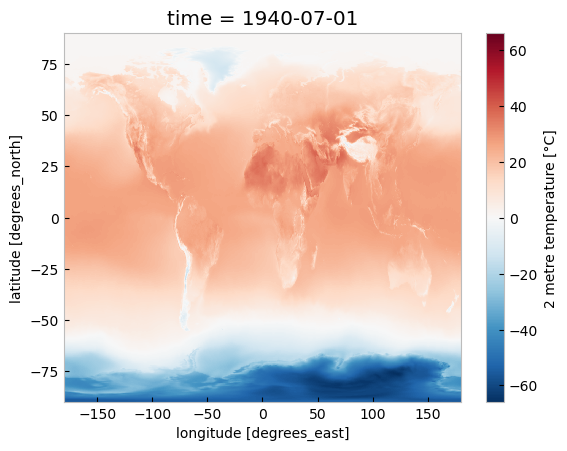

In [13]:
da_celsius.sel(time='1940').plot()

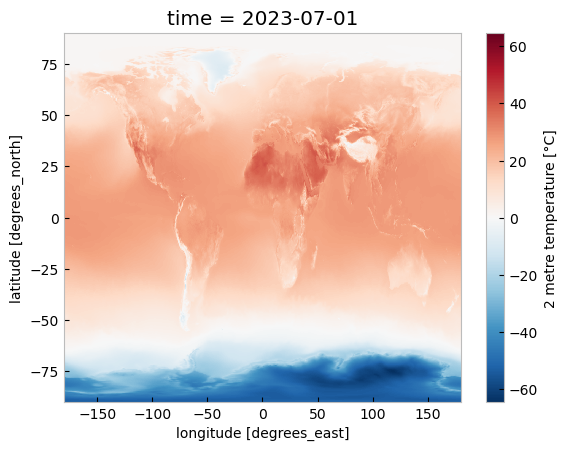

In [14]:
da_celsius.sel(time='2023').plot()

## 2. Calculate a surface temperature climatology: reference period 1991-2020

#### Standard reference periods and climatologies

Anthropogenic activities and natural variations from years to decades shape the Earth's climate. In order to evaluate anomalous conditions for a specific month or year, the World Meteorological Organization (WMO) defines `standard reference periods` used to create `climatologies`, also known as `climate normals`. `Climatologies` can be considered as the typical climate for the period they are based on.

Until 2020, the most current and widely used standard reference period was the 30-year range of 1981-2010. With the start of 2021, the WMO recommended updating the climate normal reference period to the range 1991-2020.

First, let us calculate the temperature climatology for July during the reference period 1991-2020. For this, we will select the reference period and then average along the `time` dimension. The resulting object contains the average July mean surface air temperature on each grid point.

In [15]:
t2m_ref_per = da_celsius.sel(time=slice('1991-01-01', '2020-12-31')).mean(dim='time')

If we have a look at this data object we will see now we have only two coordinates, `latitude` and `longitude`.

In [16]:
t2m_ref_per

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[  0.74816996,   0.74816996,   0.74816996, ...,   0.74816996,
          0.74816996,   0.74816996],
       [  0.7403127 ,   0.74037373,   0.7404948 , ...,   0.73977053,
          0.74001056,   0.74019164],
       [  0.72756857,   0.7276896 ,   0.7279307 , ...,   0.726238  ,
          0.7267222 ,   0.7272064 ],
       ...,
       [-55.41742   , -55.414043  , -55.41071   , ..., -55.427814  ,
        -55.42436   , -55.420856  ],
       [-55.408604  , -55.40709   , -55.40564   , ..., -55.413795  ,
        -55.41198   , -55.410347  ],
       [-55.04577   , -55.04577   , -55.04577   , ..., -55.04577   ,
        -55.04577   , -55.04577   ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

We can also make a quick plot to have an exploratory view of this new `xarray.DataArray`:

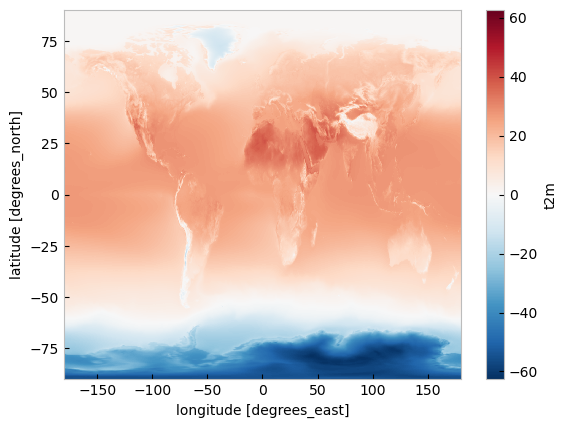

In [17]:
t2m_ref_per.plot()

## 3. Visualise surface temperature anomalies

The next step is now to calculate the anomaly for July 2023 with respect to the climatology (1991-2020). The term anomaly refers to the deviation of a value from the long-term average. Positive or negative anomalies indicate that the average temperatures of a particular month were respectively warmer or cooler than the reference value for the same month.

Let us calculate the temperature anomaly for the year 2023. In a first step, we select the average near-surface temperature values for the year 2023 from the `xarray.DataArray` object `da_celsius`. As commented before, with the xarray method `sel()`, you can select a data array based on coordinate labels. The coordinate label of interest is `year='2023'`. As we are not doing, for instance, an aggregation operation like the mean over a dimension we will have the `time` dimension in the resulting data array. To remove the `time` dimension we can use the `squeeze` method.

In [18]:
t2m_july2023 = da_celsius.sel(time='2023')

In [19]:
t2m_july2023

<xarray.DataArray 't2m' (time: 1, latitude: 721, longitude: 1440)>
array([[[  0.73760986,   0.73760986,   0.73760986, ...,   0.73760986,
           0.73760986,   0.73760986],
        [  0.7321472 ,   0.7321472 ,   0.7321472 , ...,   0.7321472 ,
           0.7321472 ,   0.7321472 ],
        [  0.72128296,   0.72128296,   0.72128296, ...,   0.72128296,
           0.72128296,   0.72128296],
        ...,
        [-53.12979   , -53.12616   , -53.122543  , ..., -53.14067   ,
         -53.135223  , -53.131607  ],
        [-53.238525  , -53.236725  , -53.23491   , ..., -53.243973  ,
         -53.243973  , -53.242157  ],
        [-53.29471   , -53.29471   , -53.29471   , ..., -53.29471   ,
         -53.29471   , -53.29471   ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2023-07-01
Attributes:
    units:      °C
    long_name:  2 metre temperature

In [20]:
t2m_july2023 = t2m_july2023.squeeze('time')

In [21]:
t2m_july2023

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[  0.73760986,   0.73760986,   0.73760986, ...,   0.73760986,
          0.73760986,   0.73760986],
       [  0.7321472 ,   0.7321472 ,   0.7321472 , ...,   0.7321472 ,
          0.7321472 ,   0.7321472 ],
       [  0.72128296,   0.72128296,   0.72128296, ...,   0.72128296,
          0.72128296,   0.72128296],
       ...,
       [-53.12979   , -53.12616   , -53.122543  , ..., -53.14067   ,
        -53.135223  , -53.131607  ],
       [-53.238525  , -53.236725  , -53.23491   , ..., -53.243973  ,
        -53.243973  , -53.242157  ],
       [-53.29471   , -53.29471   , -53.29471   , ..., -53.29471   ,
        -53.29471   , -53.29471   ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2023-07-01
Attributes:
    units:      °C
    long_name:  2 metre temperature

The anomaly will be the difference between `t2m_july2023` and `t2m_ref_per`. A positive value means July 2023 is above the expected mean:

In [22]:
anom = t2m_july2023 - t2m_ref_per

The previous operation results in the anomaly on each longitude and latitude location stored in the `anom` data array. We can plot this in a map to check where the anomaly was positive (July 2023 warmer than the climatology) or negative (July 2023 colder than the climatology). This time we will create the plot using the `matplotlib` and `cartopy` libraries.

The code below is briefly commented in the code cell. The key part is [`plt.pcolormesh`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html), which is used to plot the 2D data array on each (longitude, latitude) grid cell. The colours are defined using the `RdBr_r` colormap in a range between -12 and 12 (ºC). This is a [diverging colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging) that goes from red to blue but in reverse order, this is why it has the `_r` suffix. So, in this specific case, -12 degrees is shown in dark blue, 12 in dark red and 0, equal to the climate normal, in white.

C:\Users\cxcs\AppData\Local\anaconda3\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


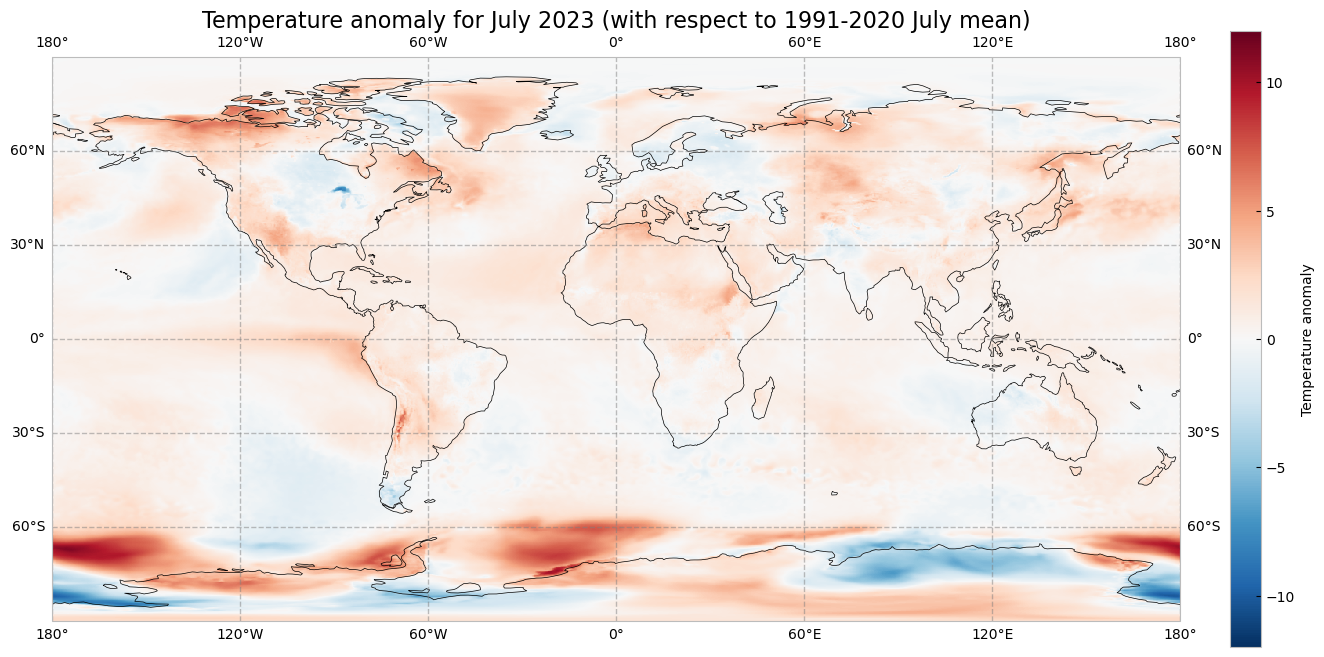

In [23]:
# create the figure panel and the map using the Cartopy PlateCarree projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
im = plt.pcolormesh(
    anom.longitude, 
    anom.latitude, 
    anom, 
    cmap='RdBu_r',
    vmin=-12, 
    vmax=12
) 

# Set the figure title, add lat/lon grid and coastlines
ax.set_title('Temperature anomaly for July 2023 (with respect to 1991-2020 July mean)', fontsize=16)
ax.gridlines(
    draw_labels=True, 
    linewidth=1, 
    color='gray', 
    alpha=0.5, 
    linestyle='--'
) 
ax.coastlines(color='black')

# Specify the colorbar and set a label for the colorbar
cbar = plt.colorbar(im, fraction=0.05, pad=0.04)
cbar.set_label('Temperature anomaly') 

# Show or save the figure, uncomment the line/s in case of need
#fig.show() # not needed in a notebook inline context
#fig.savefig('near_sfc_t2m_anomaly_july2023.png') # not needed in a notebook inline context

## 4. View time series and analyse surface temperature trends

Now let us view the time series from 1940 to 2023 averaged over the entire region. To do this we need to average `da_celsius` over the latitude and longitude dimensions. A very important consideration however is that the gridded data cells do not all correspond to the same areas. The size covered by each data point on the model grid varies as a function of latitude. We need to take this into account when calculating spatial averages. 

One way to do this is to use the cosine of the latitude as a proxy for the varying sizes.

Another way would be to use [**cdo** that would take into account the varying cell area](https://stackoverflow.com/a/65353505). The command to do this is `cdo fldmean in.nc out.nc`. 

In order to keep things simple we will stick to the solution using `xarray`.

First we calculate the weights by using the cosine of the latitude (in radians), then we apply these weights to the data array with the xarray method `weighted()`.

In [24]:
weights = np.cos(np.deg2rad(da_celsius.latitude))
weights.name = "weights"
da_celsius_weighted = da_celsius.weighted(weights)

Then we calculate the weighted mean so we will have a time series with the spatially averaged July `t2m` from 1940 to 2023.

In [25]:
t2m_global = da_celsius_weighted.mean(["longitude", "latitude"])

Let's look at the new data array:

In [26]:
t2m_global

<xarray.DataArray 't2m' (time: 84)>
array([15.77934  , 15.686103 , 15.504397 , 15.487048 , 15.6968975,
       15.581223 , 15.651366 , 15.686947 , 15.634245 , 15.671638 ,
       15.516496 , 15.5618305, 15.688131 , 15.727703 , 15.497699 ,
       15.466434 , 15.449099 , 15.652505 , 15.743765 , 15.700156 ,
       15.6520195, 15.736965 , 15.687653 , 15.801527 , 15.725807 ,
       15.596119 , 15.820597 , 15.70142  , 15.635535 , 15.702868 ,
       15.712927 , 15.525745 , 15.812478 , 15.777739 , 15.529215 ,
       15.500252 , 15.572601 , 15.78937  , 15.741149 , 15.731902 ,
       16.02006  , 15.987883 , 15.89143  , 15.912935 , 15.697611 ,
       15.693814 , 15.780967 , 16.140322 , 16.032246 , 15.991822 ,
       16.151453 , 16.181696 , 15.76771  , 15.878968 , 15.954252 ,
       16.124987 , 16.022484 , 16.056824 , 16.35066  , 16.026937 ,
       15.991144 , 16.208387 , 16.262844 , 16.181667 , 15.953027 ,
       16.3142   , 16.23219  , 16.235216 , 16.20543  , 16.36655  ,
       16.280819 , 16.371893 , 16.269135 , 16.203815 , 16.294592 ,
       16.38251  , 16.589348 , 16.494429 , 16.50715  , 16.625692 ,
       16.554085 , 16.559622 , 16.606188 , 16.953045 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1940-07-01 1941-07-01 ... 2023-07-01

We will calculate the climatology for this global spatially averaged July `t2m`. This value will be used later to check which years have global average 2m temperature above or below the climatology.

In [27]:
t2m_global_ref_per = t2m_global.sel(time=slice('1991-01-01', '2020-12-31')).mean(dim='time')
print(f'{t2m_global_ref_per.values:.2f} \N{DEGREE SIGN}C')

16.23 °C


We will create a constant array with the climatology value that has the same length as the time series:

In [28]:
t2m_clim = t2m_global_ref_per.mean().values

Let's plot the mean value since 1940. The values below the climatology will be highlighted in light blue while the values above the climatology will be highlighted in red. Code is commented in the code cell below.

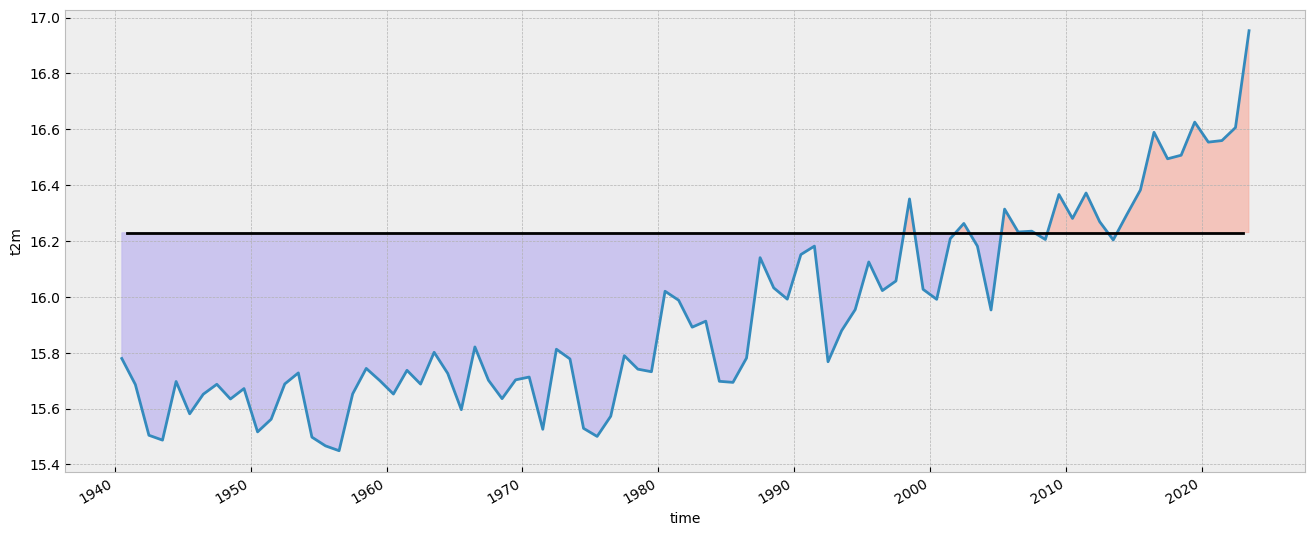

In [29]:
# create the figure panel and the axes
fig, ax = plt.subplots(figsize=(16, 6))

# we use the xarray plot method passing the axes we want to use
# to plot the global time series from 1940 to 2023
t2m_global.plot(ax=ax)

# we use the t2m_clim variable to plot a horizontal line
# with the global climate normal value (1991-2020)
ax.axhline(y=t2m_clim, xmin = 0.05, xmax = 0.95, color='black')

# In order to highlight years above or below the global climate value
# we use two times the fill_between method that fills the area between two lines
# The first one is for values below the global climate normal in 'mediumslateblue' color
ax.fill_between(
    t2m_global.time, 
    t2m_global, 
    t2m_clim, 
    where=(t2m_global < t2m_clim), 
    color='mediumslateblue', 
    alpha=0.3,
    interpolate=True
)
# The second one is for values above the global climate normal in 'tomato' color
ax.fill_between(
    t2m_global.time, 
    t2m_global, 
    t2m_clim, 
    where=(t2m_global > t2m_clim), 
    color='tomato', 
    alpha=0.3,
    interpolate=True
)

# Show or save the figure, uncomment the line/s in case of need
#fig.show() # not needed in a notebook inline context
#fig.savefig('near_sfc_t2m_global_avg_july.png') # not needed in a notebook inline context

Could you try a similar figure but using the anomalies (*"monthly value" - "1991-2020 climatological value"*) instead of the spatially aggregated average monthly values?

In [30]:
# Your code here

Now let's order the months from colder to warmer.

In [31]:
t2m_global_sorted = t2m_global.sortby(t2m_global)

Let's have a look to the result and check if it is sorted.

In [32]:
t2m_global_sorted

<xarray.DataArray 't2m' (time: 84)>
array([15.449099 , 15.466434 , 15.487048 , 15.497699 , 15.500252 ,
       15.504397 , 15.516496 , 15.525745 , 15.529215 , 15.5618305,
       15.572601 , 15.581223 , 15.596119 , 15.634245 , 15.635535 ,
       15.651366 , 15.6520195, 15.652505 , 15.671638 , 15.686103 ,
       15.686947 , 15.687653 , 15.688131 , 15.693814 , 15.6968975,
       15.697611 , 15.700156 , 15.70142  , 15.702868 , 15.712927 ,
       15.725807 , 15.727703 , 15.731902 , 15.736965 , 15.741149 ,
       15.743765 , 15.76771  , 15.777739 , 15.77934  , 15.780967 ,
       15.78937  , 15.801527 , 15.812478 , 15.820597 , 15.878968 ,
       15.89143  , 15.912935 , 15.953027 , 15.954252 , 15.987883 ,
       15.991144 , 15.991822 , 16.02006  , 16.022484 , 16.026937 ,
       16.032246 , 16.056824 , 16.124987 , 16.140322 , 16.151453 ,
       16.181667 , 16.181696 , 16.203815 , 16.20543  , 16.208387 ,
       16.23219  , 16.235216 , 16.262844 , 16.269135 , 16.280819 ,
       16.294592 , 16.3142   , 16.35066  , 16.36655  , 16.371893 ,
       16.38251  , 16.494429 , 16.50715  , 16.554085 , 16.559622 ,
       16.589348 , 16.606188 , 16.625692 , 16.953045 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1956-07-01 1955-07-01 ... 2023-07-01

If we plot the ranking from colder to warmer including also the climate normal we'll see the following. As before, code is commented in the code cell below:

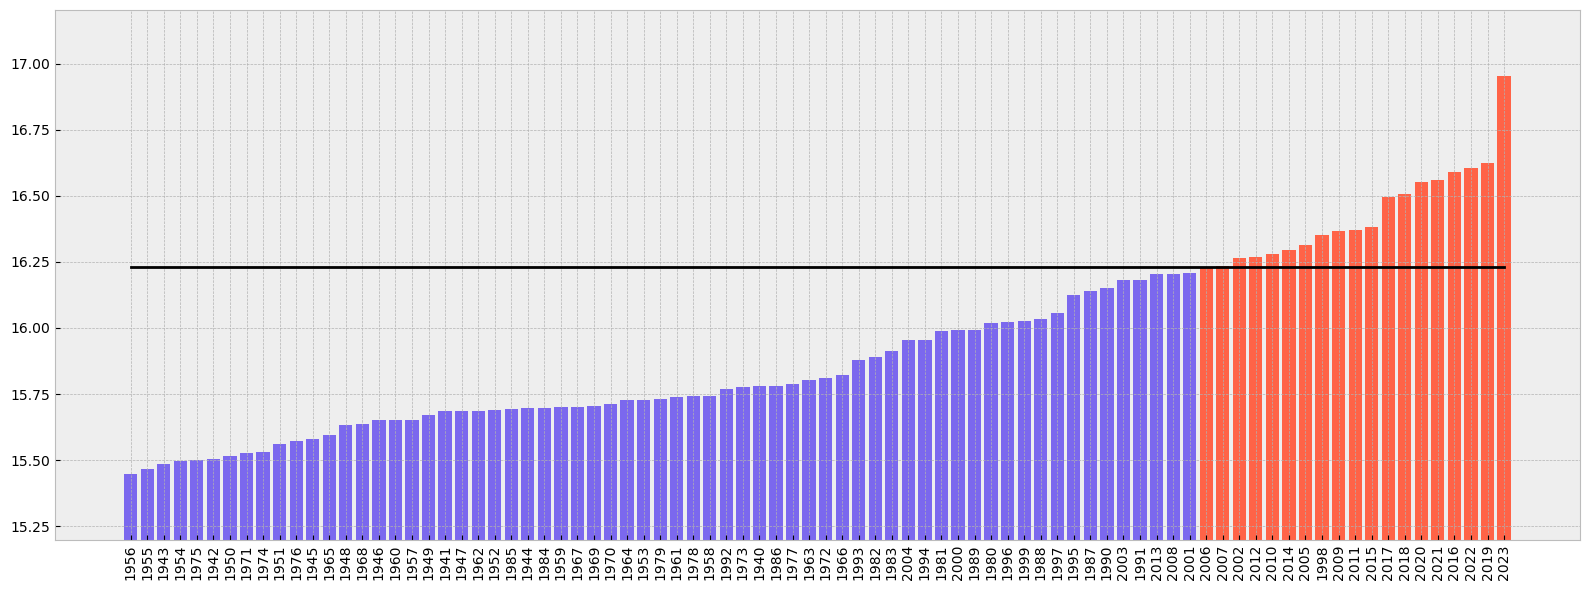

In [33]:
# create the figure panel and the axes
fig, ax = plt.subplots(figsize=(16, 6))

# We create a label for the 'x' axis using each year
xlabel = t2m_global_sorted.time.values.astype('datetime64[Y]').astype(int) + 1970 # years

# We create also the location for each of the labels in the 'x' axis
xpos = np.arange(len(xlabel))

# We extract the sorted values to be used as the 'y' values
y = t2m_global_sorted.values

# We create a bar plot of all the bars using 'tomato' color
ax.bar(xpos, y, color='tomato')

# We place all the labels for the 'x' axis rotated 90º
ax.set_xticks(xpos, xlabel, rotation=90)

# Now we create a mask with the values below the climate normal
mask = y < t2m_clim

# and plot again those values below the climate normal but now using the 'mediumslateblue' color
ax.bar(xpos[mask], y[mask], color='mediumslateblue')

# We limit the range of the 'y' axis to the (minimum - 0.25) and the (maximum + 0.25)
ax.set_ylim(t2m_global_sorted.min() - 0.25, t2m_global_sorted.max() + 0.25)

# we add a horizontal line to plot the climate normal.
#ax.plot(range(len(clim_repeated)), clim_repeated, '-.', linewidth=0.5, color='black')
ax.axhline(y=t2m_clim, xmin = 0.05, xmax = 0.95, color='black')

# This function is very interesting as it does magic to prettify the final result :-)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html
fig.tight_layout()

# Show or save the figure, uncomment the line/s in case of need
#fig.show() # not needed in a notebook inline context
#fig.savefig('near_sfc_t2m_global_avg_july_sorted_barplot.png') # not needed in a notebook inline context

## 5. View time series and analyse North Atlantic sea surface temperature trends

#### This is a new exercise. In this part of the tutorial we will be working with monthly sea surface temperature (SST) data.

First we need to download a new dataset. As before, we need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab in the CDS ([https://cds-beta.climate.copernicus.eu](https://cds-beta.climate.copernicus.eu)). In this tab a form appears in which we select the following parameters to download:

- Product type: `Monthly averaged reanalysis`
- Variable: `sea_surface_temperature`
- Year: `1991 to 2023`
- Month: `all`
- Time: `00:00` (default)
- Geographical area: `60, -40, 0, 0` 
- Format: `NetCDF`

Below you can see the API request:

In [34]:
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'data_format': 'netcdf_legacy',
        'variable': 'sea_surface_temperature',
        'product_type': 'monthly_averaged_reanalysis',
        'year': [
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
            '2021', '2022', '2023',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': [
            60, -40, 0,
            0,
        ],
    },
    f'{DATADIR}sst_(NAtl)_monthly_1991-2023.nc'
)

2024-06-16 21:49:25,957 INFO Welcome to the CDS
2024-06-16 21:49:25,972 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2024-06-16 21:49:26,095 INFO Request is queued
2024-06-16 21:49:27,162 INFO Request is running
2024-06-16 21:51:20,057 INFO Request is completed
2024-06-16 21:51:20,057 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data0/adaptor.mars.internal-1718567441.1459908-14651-8-cf3f88ba-9a09-4dac-a81f-1e02017d839d.nc to ./DATA-2024-06-16/sst_(NAtl)_monthly_1991-2023.nc (29.3M)
2024-06-16 21:51:33,978 INFO Download rate 2.1M/s                                                                      


Result(content_length=30734656,content_type=application/x-netcdf,location=https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data0/adaptor.mars.internal-1718567441.1459908-14651-8-cf3f88ba-9a09-4dac-a81f-1e02017d839d.nc)

Let's do some work with this new dataset. First of all, let's read it.

In [35]:
sst_ds = xr.open_dataset(f'{DATADIR}sst_(NAtl)_monthly_1991-2023.nc')

Now we can have a look at the dataset:

In [36]:
sst_ds

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 241, time: 396)
Coordinates:
  * longitude  (longitude) float32 -40.0 -39.75 -39.5 -39.25 ... -0.5 -0.25 0.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 1991-01-01 1991-02-01 ... 2023-12-01
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-16 19:50:42 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

As before, we see there are four dimensions and units are in *Kelvin*. We will work with data in *degrees Celsius* and we will reduce the `expver` dimension as before:

In [39]:
# remove expver and convert to ºC (no update of attrs...)
if 'expver' in sst_ds.coords:
    sst_expver = sst_ds['sst'].reduce(np.nansum, 'expver') - 273.15
else:
    sst_expver = sst_ds['sst'] - 273.15

We can have a quick look at the data using the convenient `plot` method:

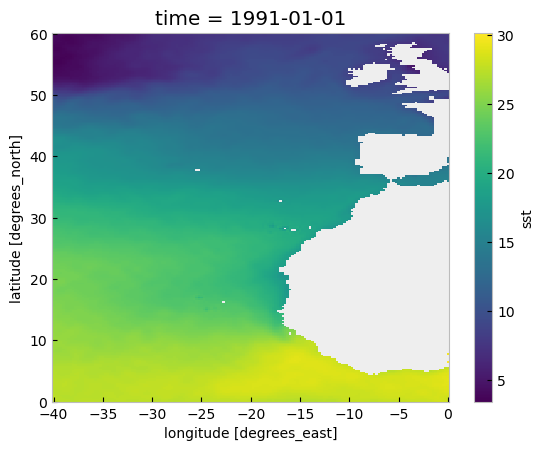

In [40]:
sst_expver.sel(time='1991/01').plot()

In the plot above we can see many values are below 0, those located on land. Actually, in the original `sst_ds` `xarray.Dataset` the land positions had a value of `numpy.nan`. Now, for `sst_expver` this is not true. This is a result of the previous operation using `numpy.nansum` and subtracting `273.15`. After this operation the land locations have a value of `-273.15` which is not valid. Let's amend this using a mask:

In [41]:
# add a mask for LAND
mask = sst_expver.values > -273.15
sst_masked = sst_expver.where(mask)

Again, as before, we weight the dataset by the area:

In [42]:
# Add weights for area
weights = np.cos(np.deg2rad(sst_masked.latitude))
weights.name = "weights"
sst_weights = sst_masked.weighted(weights)

And, also, we calculate the spatially averaged value for each month to get a monthly time series of the average temperature of the sst over the main area of the North Atlantic from January 1991 to July 2023:

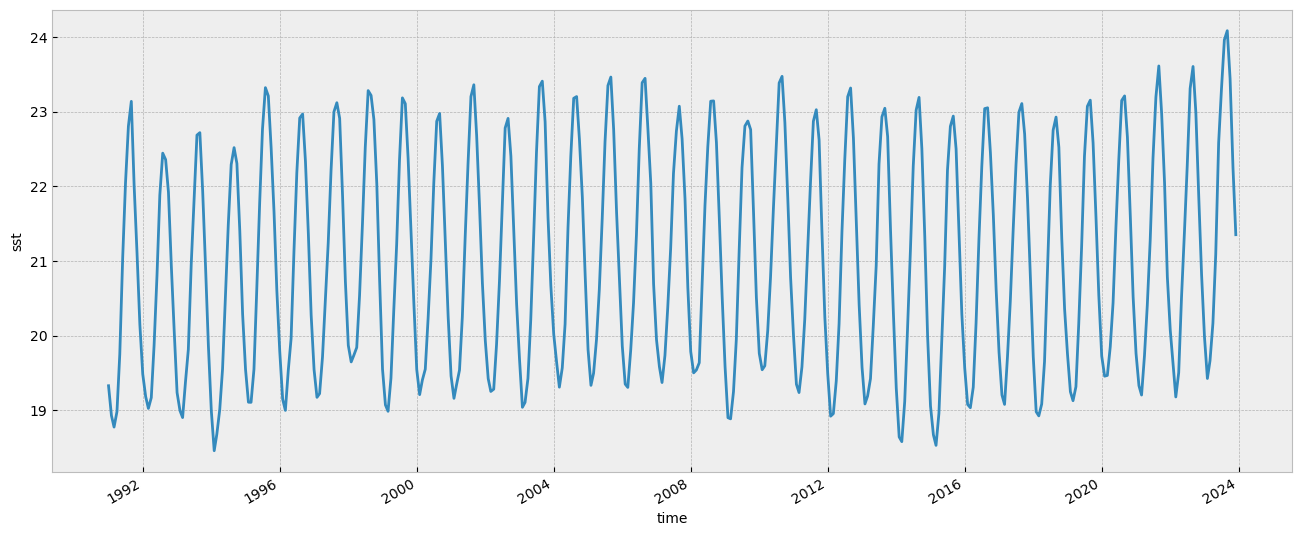

In [43]:
# Aggregate on Lon/Lat to get a time series of the area
sst_ts = sst_weights.mean(["longitude", "latitude"])
sst_ts.plot(figsize=(16, 6))

In the plot above we can see the monthly evolution since 1991.

We calculate the minimum, the maximum and the average value for each of the 12 months of the year during the climatological reference (1991-2020):

In [44]:
# Min value on each month during the climatology period
min_per_month_clim = sst_ts.sel(
    time=slice('1991-01-01', '2020-12-31')
).groupby('time.month').min()

# Max value on each month during the climatology period
max_per_month_clim = sst_ts.sel(
    time=slice('1991-01-01', '2020-12-31')
).groupby('time.month').max()

# avg value on each month during the climatology period
avg_per_month_clim = sst_ts.sel(
    time=slice('1991-01-01', '2020-12-31')
).groupby('time.month').mean()

And once we have this we can compare how recent SST values compare with those of previous years and to the climatology.

In the figure below we will plot the monthly time series for the following:

* Each year for the period from 1991 to 2020 (light gray).
* The 1991-2020 average (thick gray line).
* 2022 (thick orange line).
* 2023 (January to July, thick black line).

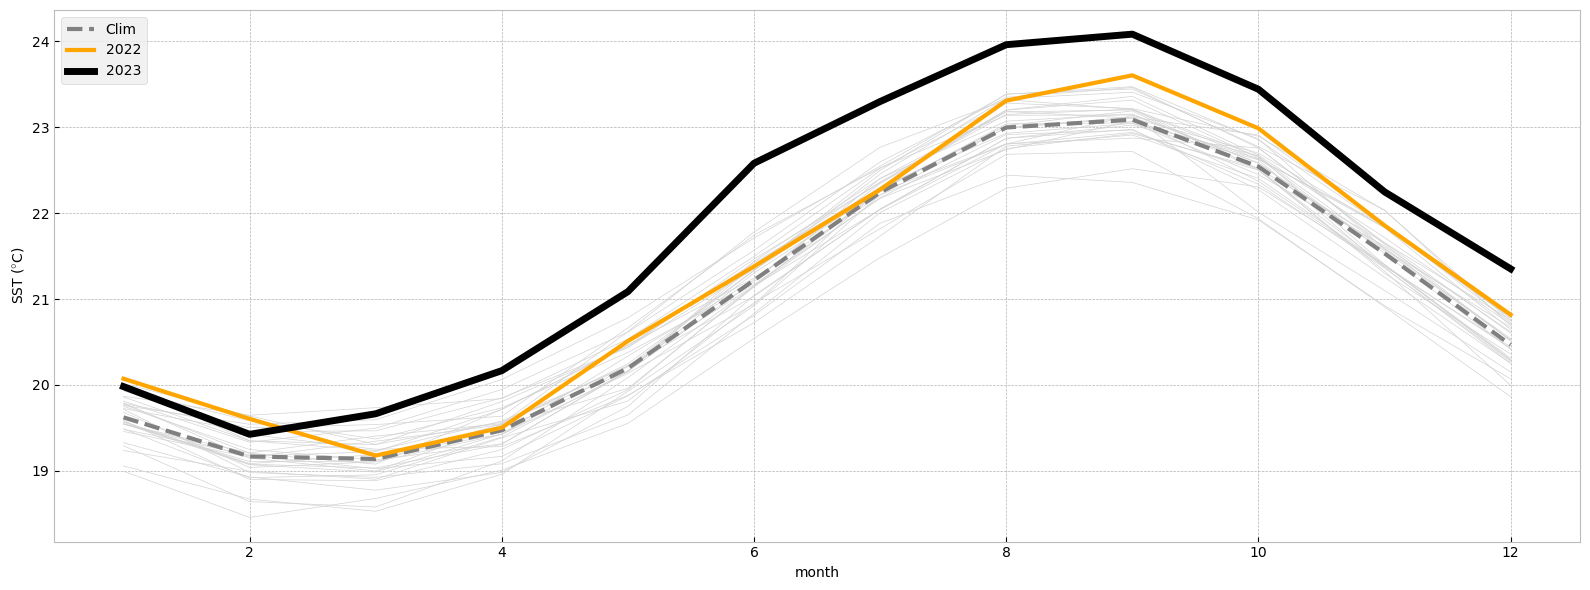

In [46]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set_facecolor('white') # For this plot we want a white axes background 

# Thin line for each year from 1991 to 2020
for year in range(1991, 2021):
    ax.plot(range(1, 13), sst_ts.sel(time=str(year)), color='lightgrey', lw=0.5)

# Climatological average
ax.plot(range(1, 13), avg_per_month_clim, '--', color='grey', lw=3, label='Clim')

# Monthly average for 2022
ax.plot(range(1, 13), sst_ts.sel(time='2022'), color='orange', lw=3, label='2022')

# Monthly average for 2023
ax.plot(range(1, 13), sst_ts.sel(time='2023'), color='black', lw=5, label='2023')

# Customise the plot
ax.set_xlabel('month')
ax.set_ylabel('SST ($\degree$C)')
ax.legend(loc='upper left')
fig.tight_layout()

# Show or save the figure, uncomment the line/s in case of need
#fig.show() # not needed in a notebook inline context
#fig.savefig('SST_NorthAtlantic_avg.png') # not needed in a notebook inline context

Notice the dramatic increase in SST over the North Atlantic in 2023 compared to previous years!